# Beta skeletons
This notebook shows how to draw [beta-skeletons](https://en.wikipedia.org/wiki/Beta_skeleton) using [clesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) on a graphics processing unit.
Furthermore, for user convenience, a napari plugin can be found on the bottom where the user can change beta interactively. To make this notebook run on your PC, please [setup a conda environment](https://github.com/BiAPoL/Bio-image_Analysis_with_Python/blob/main/conda_basics/01_conda_environments.md) and run these commands:
```
conda install -c conda-forge pyopencl
pip install pyclesperanto-prototype
pip install napari==0.4.8
pip install jupyter
```

First, we import libraries and initialize the GPU

In [1]:
import numpy as np
import pyclesperanto_prototype as cle

cle.get_device()

<Intel(R) UHD Graphics on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

This is the test data, a list of cat-shaped point coordinates.

In [2]:
import numpy as np
data = np.asarray([[2.21, 2.5 , 2.9 , 3.33, 3.79, 4.27, 4.74, 5.25, 5.66, 5.98, 6.25, 6.43, 6.47, 6.35, 6.19, 5.98, 5.8 , 5.51, 5.32, 5.19, 5.  , 4.83,4.62, 4.5 , 4.54, 4.7 , 4.82, 4.87, 4.87, 4.9 , 4.91, 4.7 , 4.47,4.2 , 3.89, 3.55, 3.53, 3.52, 3.51, 3.51, 3.4 , 3.11, 3.02, 3.17,3.16, 3.07, 3.  , 2.93, 2.81, 2.6 , 2.37, 2.11, 1.83, 1.66, 1.52,1.33, 1.37, 1.47, 1.7 , 1.91, 2.1 , 2.29, 2.54, 1.97, 1.76, 1.6 ,1.36, 1.29, 1.11, 0.87, 0.95, 0.95, 1.09, 1.31, 1.46, 1.22, 1.09,1.09, 1.3 , 1.49, 1.56, 1.95, 0.98, 0.88, 0.86, 1.04, 5.99, 6.21,6.52, 6.53, 6.53, 6.46, 6.63, 6.84, 6.88, 6.89, 6.86, 6.69, 6.56,6.55, 6.6 , 6.61, 6.77, 6.81, 6.76, 6.7 , 6.74, 6.99, 7.3 , 7.41,7.17, 6.74, 6.34, 6.17, 6.08, 6.15, 6.25, 6.21],
[3.83, 3.59, 3.49, 3.48, 3.55, 3.63, 3.65, 3.7 , 3.65, 3.58, 3.47,3.23, 2.86, 2.39, 2.02, 1.77, 1.57, 1.31, 0.94, 0.59, 0.42, 0.31,0.28, 0.37, 0.51, 0.58, 0.68, 0.91, 1.17, 1.6 , 1.81, 1.7 , 1.67,1.7 , 1.72, 1.84, 1.61, 1.33, 0.95, 0.48, 0.25, 0.21, 0.34, 0.5 ,0.63, 0.94, 1.27, 1.48, 1.61, 1.4 , 1.29, 1.1 , 0.99, 0.7 , 0.46,0.53, 0.76, 1.01, 1.3 , 1.55, 1.73, 1.92, 1.78, 2.17, 2.5 , 2.74,2.98, 2.92, 2.88, 2.97, 3.16, 3.45, 3.78, 3.92, 4.01, 4.11, 4.31,4.39, 4.34, 4.23, 4.07, 4.01, 3.91, 4.07, 4.26, 4.17, 1.32, 1.08,0.85, 0.61, 0.41, 0.26, 0.16, 0.25, 0.47, 0.81, 1.12, 1.35, 1.65,1.94, 2.4 , 3.39, 3.72, 4.18, 4.6 , 5.07, 5.51, 5.63, 5.71, 5.92,6.11, 6.11, 5.86, 5.46, 4.98, 4.57, 4.19, 3.77]])

In [3]:
flipped_data = np.asarray([data[0], max(data[1] + 1)-data[1]])

zoom = 100
point_coordinates = flipped_data * zoom

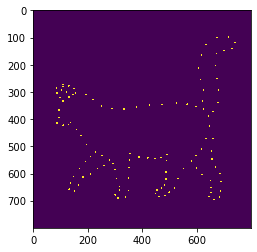

In [4]:
# draw data
spots_image = cle.create([800, 800])
cle.pointlist_to_labelled_spots(point_coordinates, spots_image)
cle.imshow(cle.maximum_sphere(spots_image, radius_x=3, radius_y=3), max_display_intensity=1)

We will connect those points according to their distances. Thus, let's take a look at a distance matrix, where distances from each point to each point are measured. The diagonale is zero as it represents the distance of each point to itself. Furthermore, in clesperanto, the first column and row correspond to the distance to the background, which is meaningless in this context. [Read more about pointlists, matrices and meshes in clesperanto.](https://nbviewer.jupyter.org/github/clEsperanto/pyclesperanto_prototype/blob/master/demo/neighbors/mesh_with_distances.ipynb).

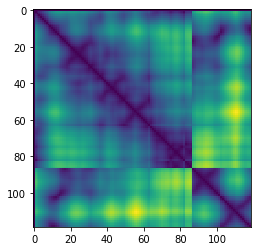

In [5]:
distance_matrix = cle.generate_distance_matrix(point_coordinates, point_coordinates)
cle.imshow(distance_matrix)

Furthermore, we will threshold the distance matrix. According to the definition of beta-skeletons, we will apply a threshold which is relative to the distance of each point to its nearest neighbor. The threshold matrix containing nearest neighbor distances as rows and columns look like this:

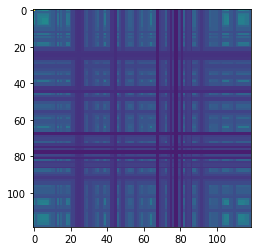

In [6]:
def make_threshold_matrix(raw_distance_matrix):
    
    distance_matrix = cle.copy(raw_distance_matrix)
    very_large_number = np.finfo(np.float32).max

    # eliminate distance to background (row 0 and column 0)
    cle.set_column(distance_matrix, 0, very_large_number)
    cle.set_row(distance_matrix, 0, very_large_number)
    # eliminate distance to self
    cle.set_where_x_equals_y(distance_matrix, very_large_number)

    # determine minimum distance in X
    minimum_distance_x = cle.minimum_x_projection(distance_matrix)
    
    
    threshold_x = cle.create_like(distance_matrix)

    cle.scale(minimum_distance_x, threshold_x, factor_x=distance_matrix.shape[1])
    threshold_matrix = cle.minimum_images(threshold_x, cle.transpose_xy(threshold_x))
    return threshold_matrix

threshold_matrix = make_threshold_matrix(distance_matrix)
cle.imshow(threshold_matrix, min_display_intensity=0, max_display_intensity = 100)

By multiplying the threshold matrix with a given `beta`, we can draw meshes corresponding to beta-skeletons.

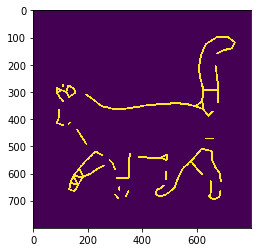

In [7]:
def draw_beta_skeleton(distance_matrix, threshold_matrix, pointlist, beta, image_size=[800, 800]):
    result = cle.create(image_size)
    
    threshold_to_apply = threshold_matrix * beta
    
    adjacency_matrix = distance_matrix <= threshold_to_apply
    
    cle.touch_matrix_to_mesh(pointlist, adjacency_matrix, result)
    
    return result

mesh = draw_beta_skeleton(distance_matrix, threshold_matrix, point_coordinates, beta=1.5)
cle.imshow(cle.maximum_sphere(mesh, radius_x=3, radius_y=3), min_display_intensity=0, max_display_intensity = 1)

For different `beta`s those look like this:

1.0


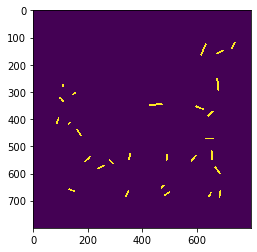

1.5


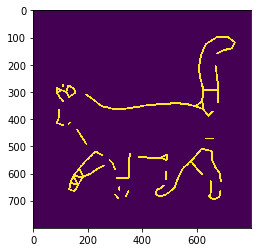

2.0


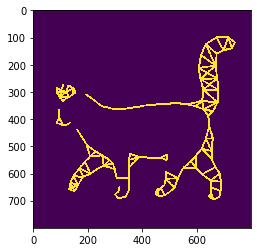

2.5


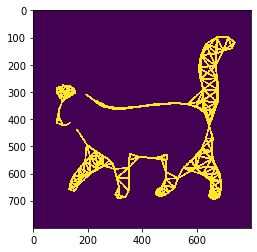

3.0


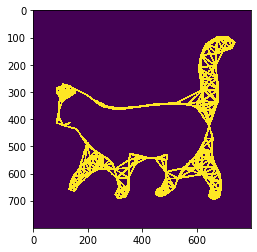

3.5


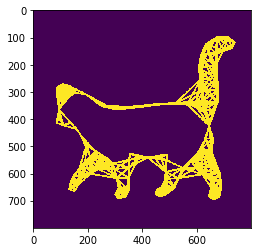

4.0


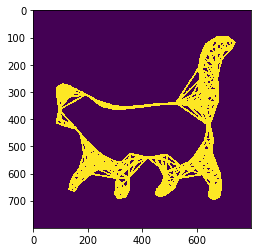

4.5


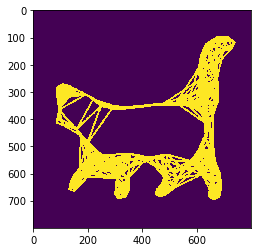

In [8]:
for beta in np.arange(1, 5, 0.5):
    mesh = draw_beta_skeleton(distance_matrix, threshold_matrix, point_coordinates, beta=beta)
    print(beta)
    cle.imshow(cle.maximum_sphere(mesh, radius_x=3, radius_y=3), min_display_intensity=0, max_display_intensity = 1)

For coder convenience, we collect all the funcitonality above in a single function.

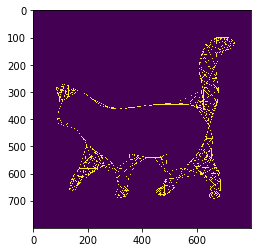

In [9]:
def connect_labels_using_beta_skeleton(labels, beta=2):
    """
    Draw a beta-skeleton from a label image. The connections are drawn between the centroids of the given labels.
    """
    coordinates = cle.centroids_of_labels(labels)
    distance_matrix = cle.generate_distance_matrix(point_coordinates, point_coordinates)
    threshold_matrix = make_threshold_matrix(distance_matrix)
    mesh = draw_beta_skeleton(distance_matrix, threshold_matrix, point_coordinates, beta=beta)
    return mesh

mesh = connect_labels_using_beta_skeleton(spots_image, beta=3)
cle.imshow(mesh)

## Napari plugin
For end-user convenience, we put the function above in a [magicgui](https://napari.org/magicgui/)-annotated function, which can be added to [napari](https://napari.org/) where the user can tune `beta` interactively.

In [10]:
import napari
from magicgui import magicgui
from napari.types import ImageData, LabelsData

@magicgui(auto_call=True)
def beta_skeleton(labels:LabelsData, beta:float = 2) -> ImageData:
    return connect_labels_using_beta_skeleton(spots_image, beta=beta)
    
viewer = napari.Viewer()
viewer.add_labels(spots_image.astype(int))

viewer.window.add_dock_widget(beta_skeleton)

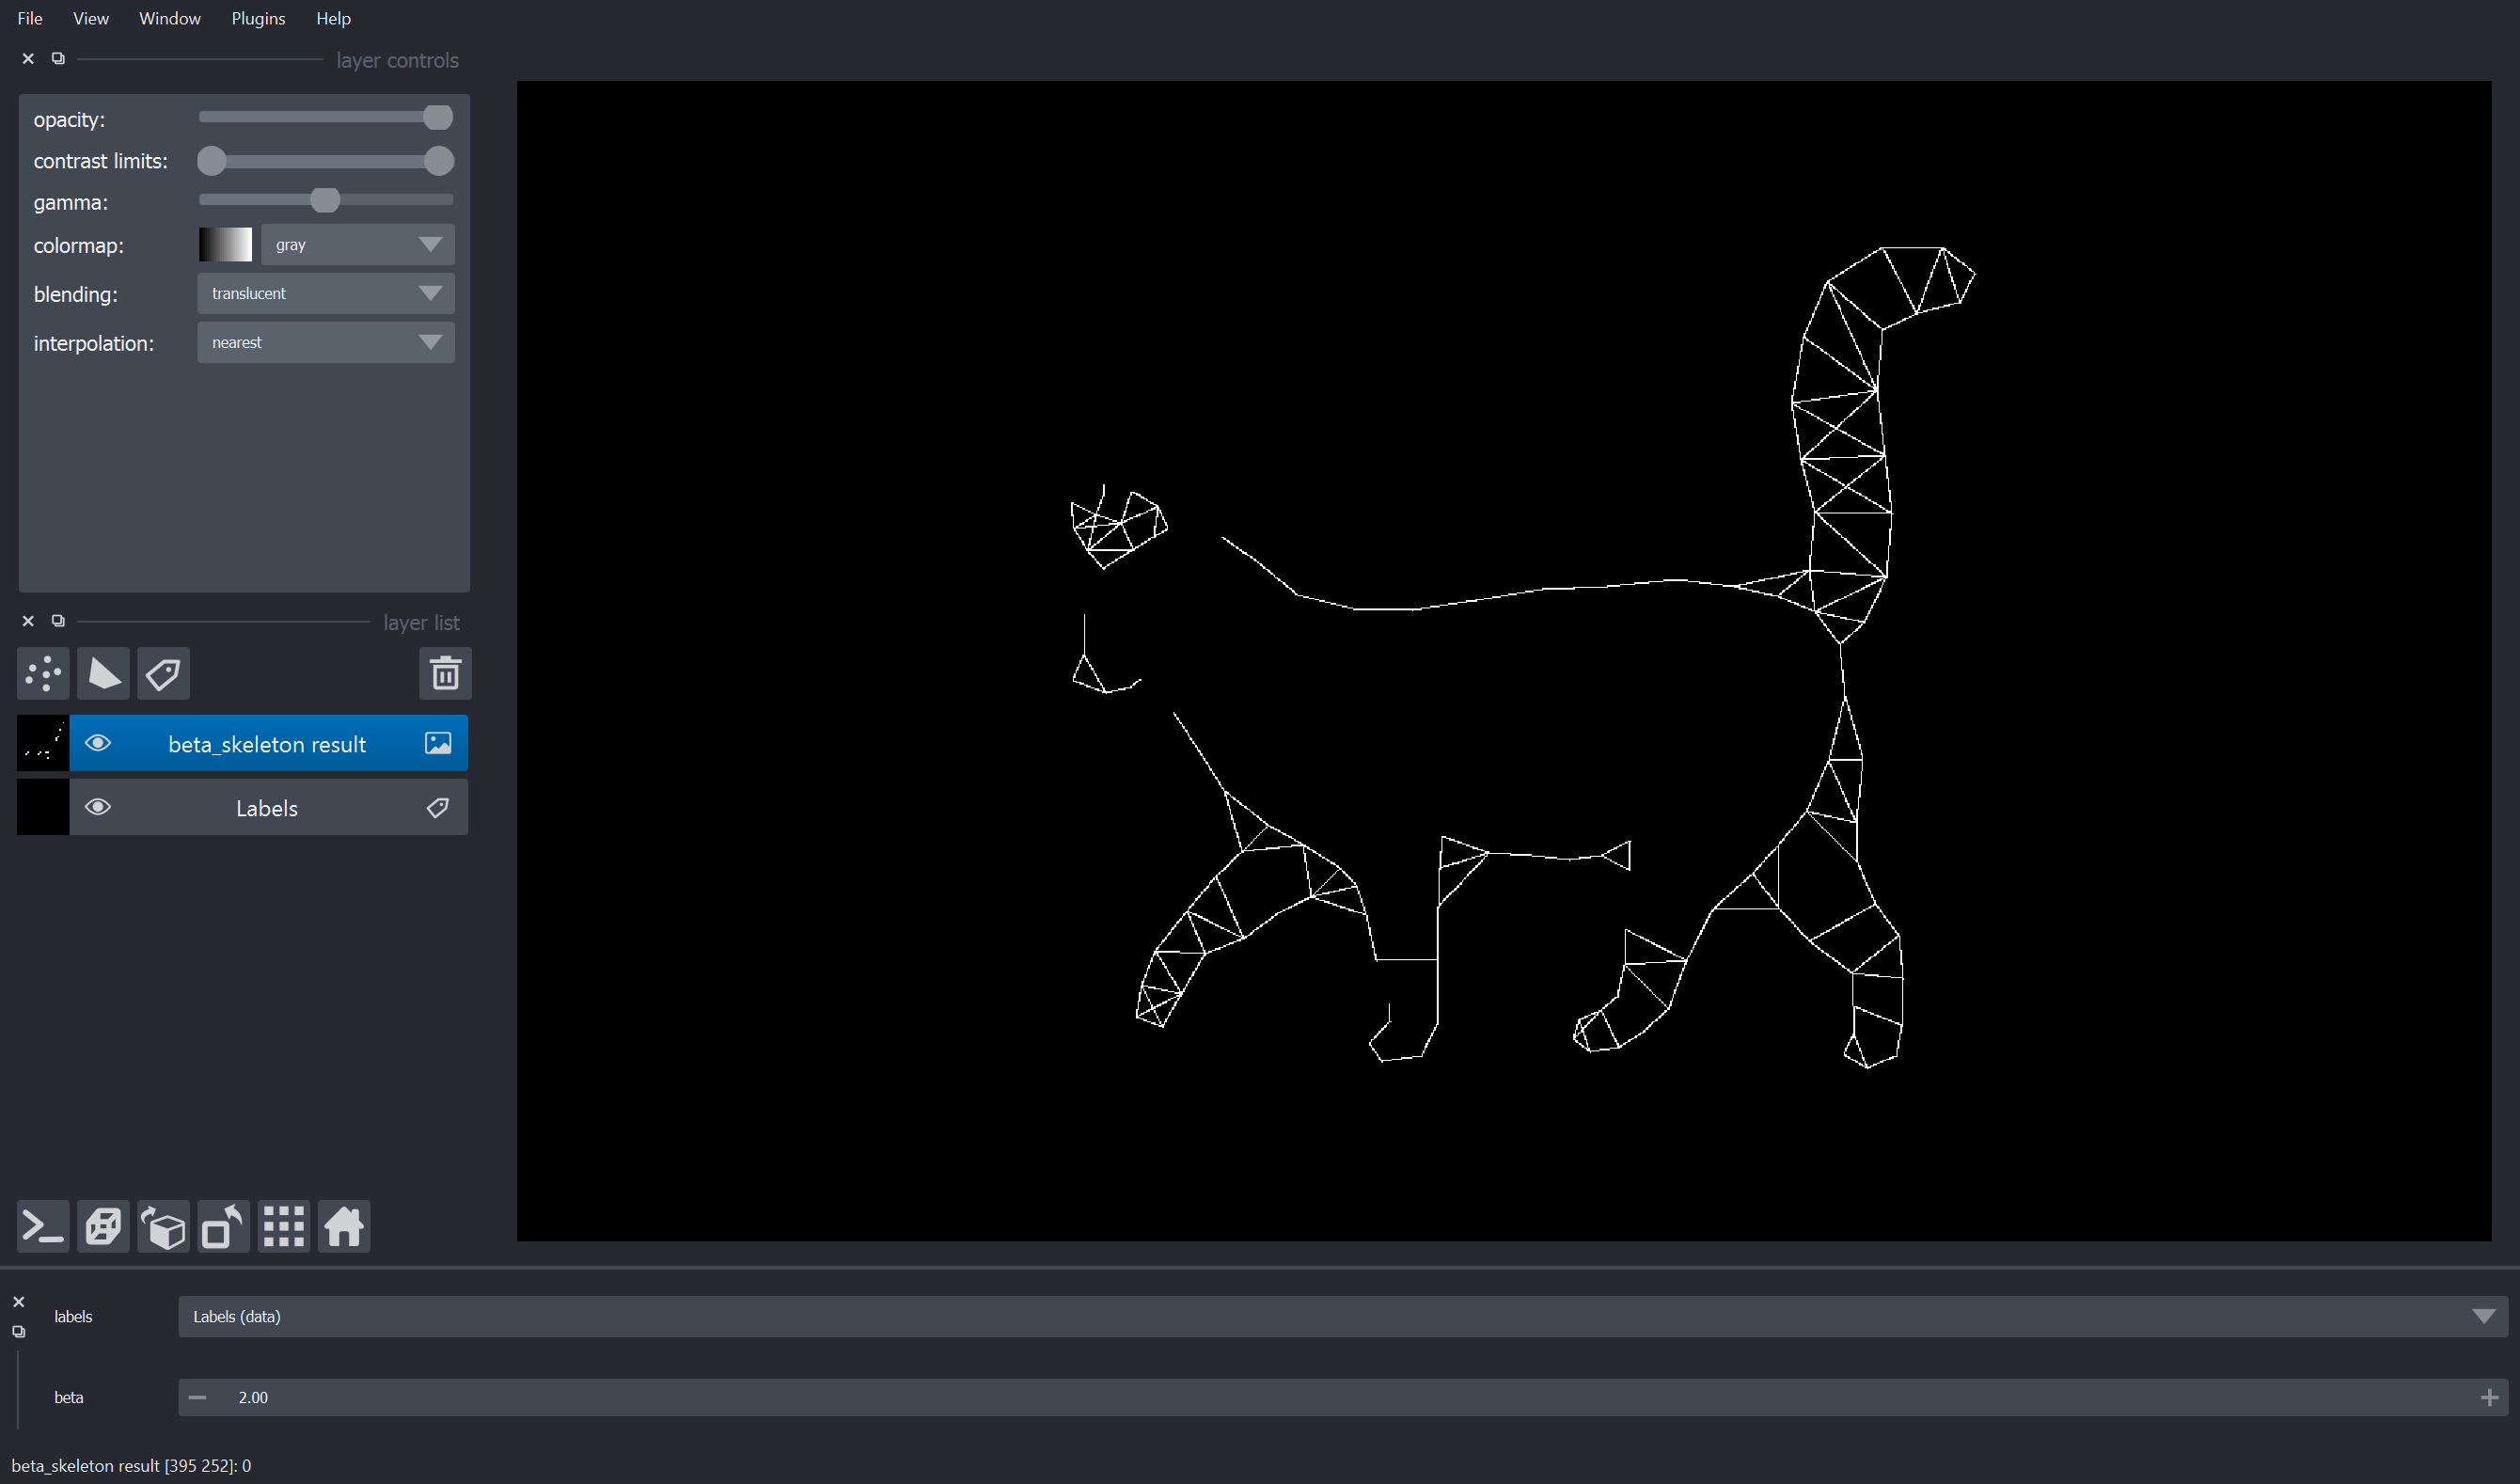

In [11]:
napari.utils.nbscreenshot(viewer)

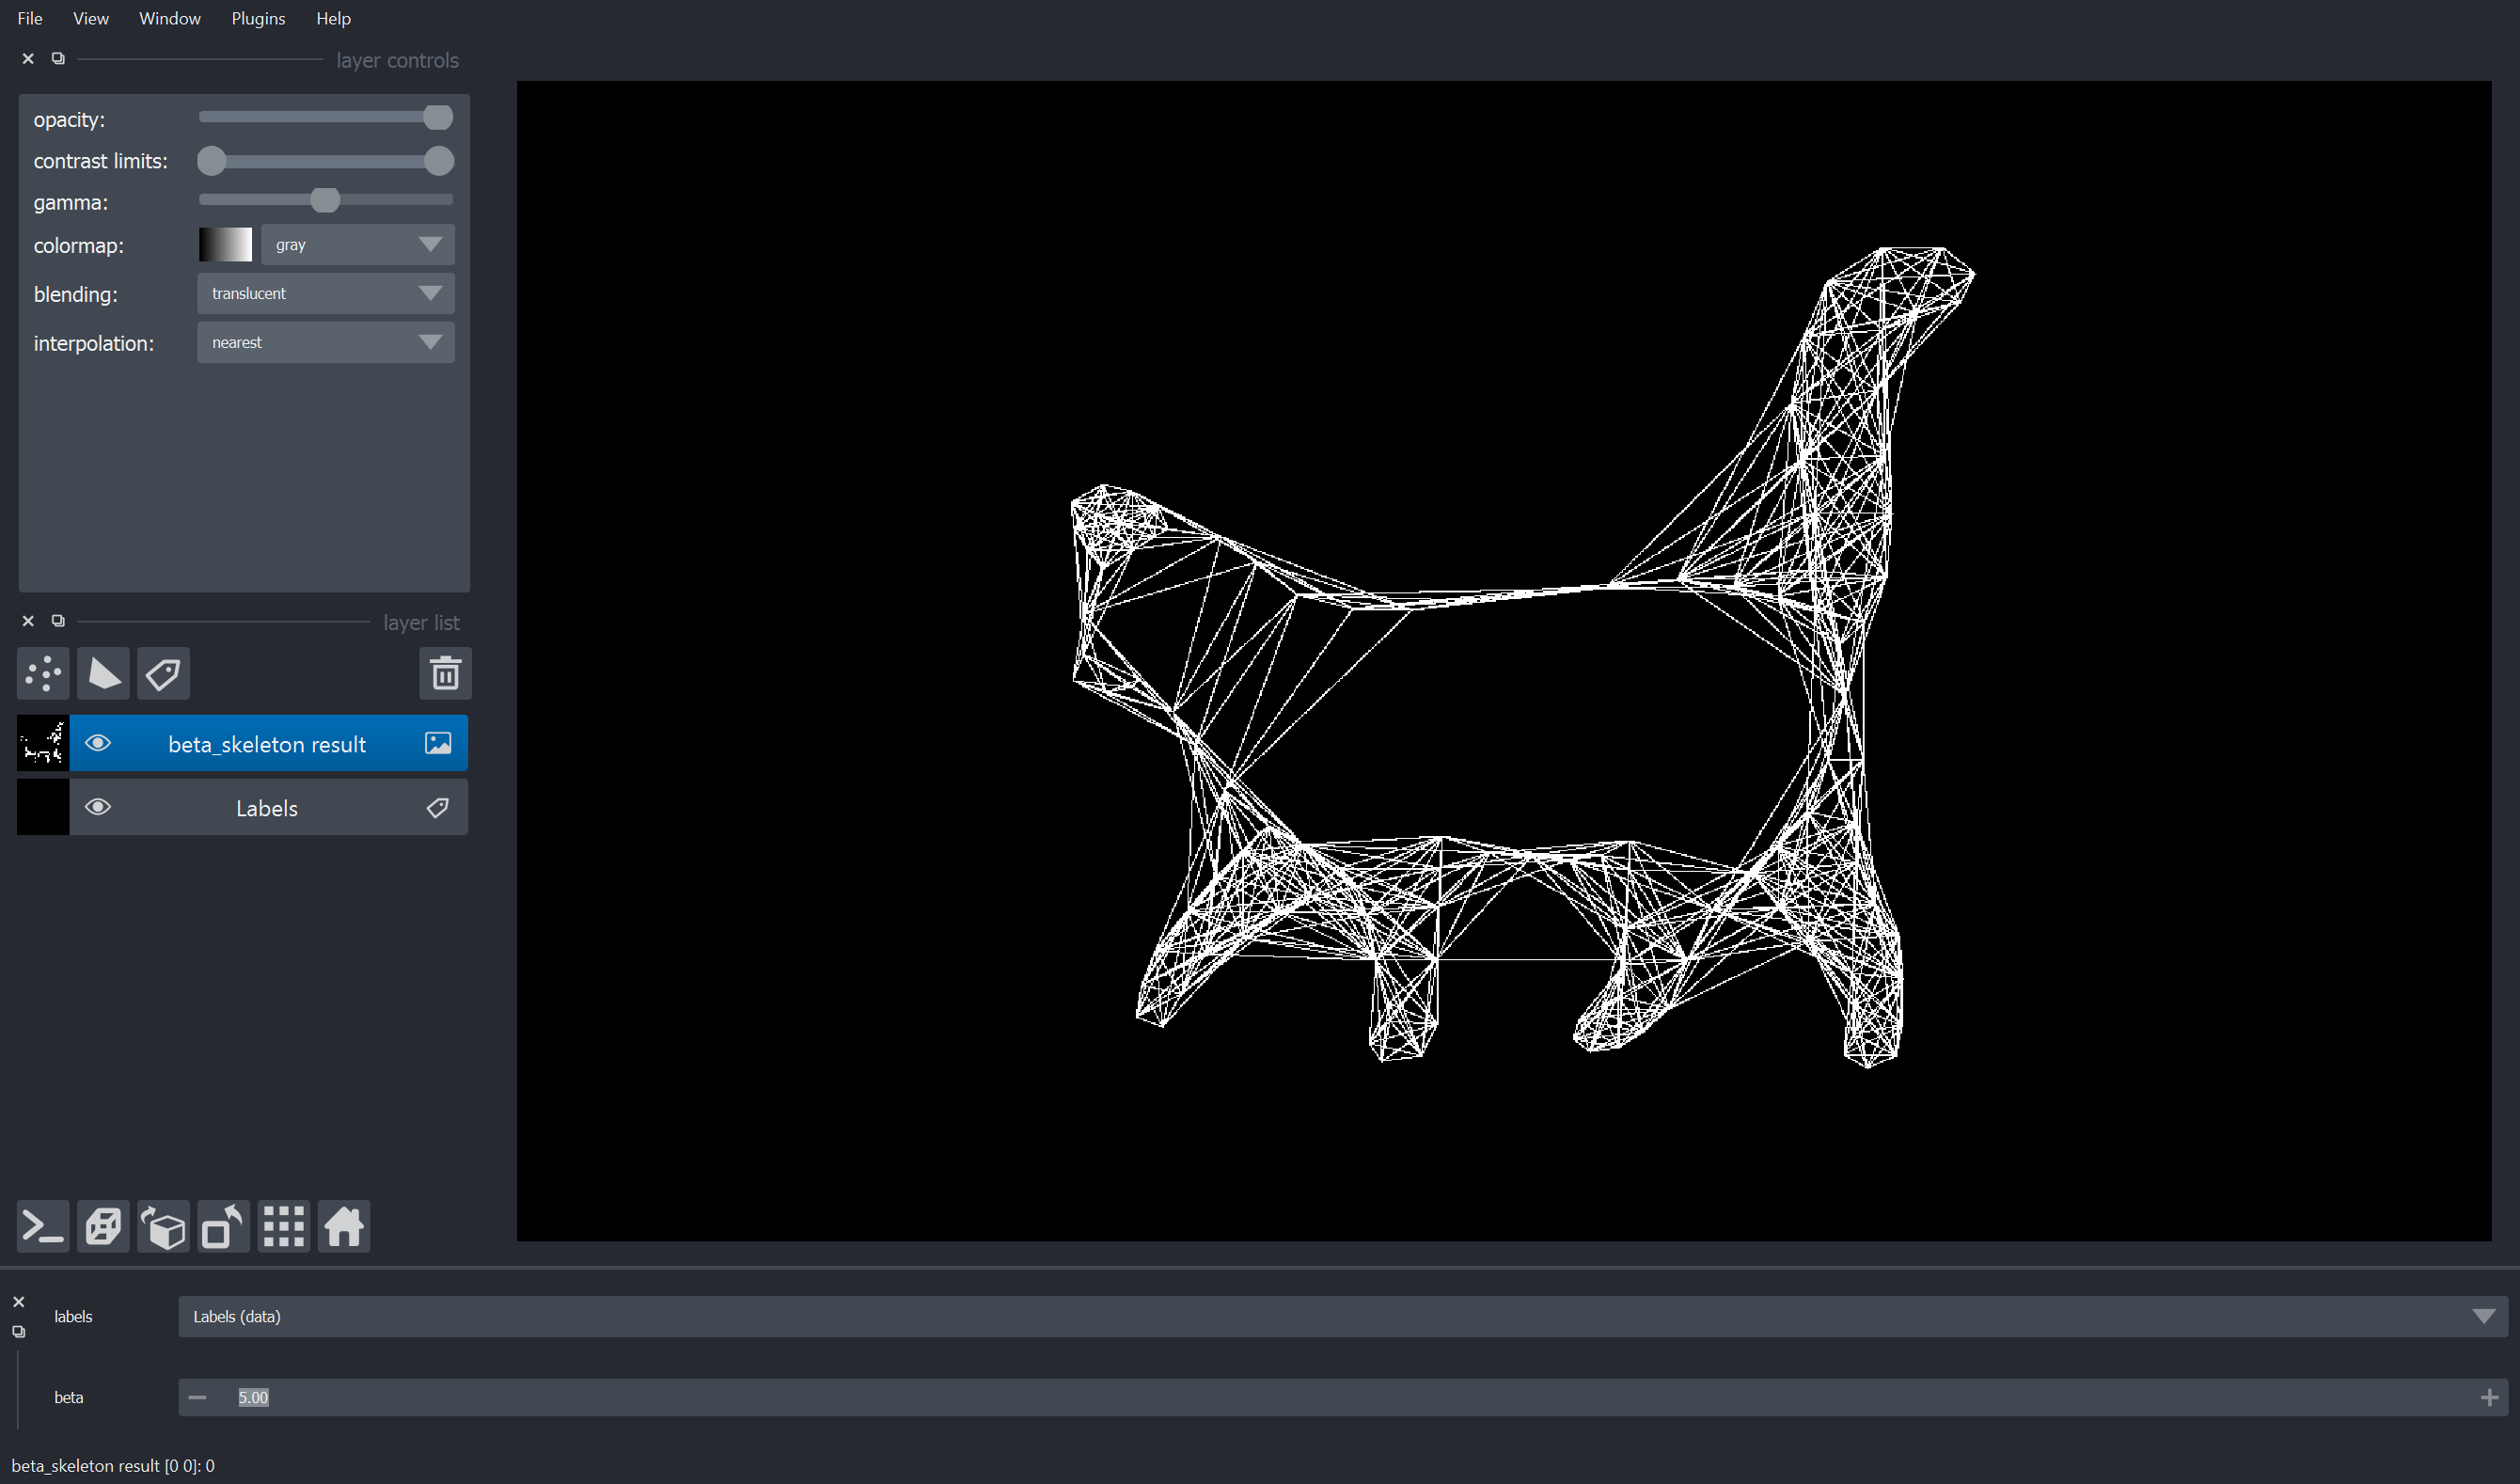

In [12]:
napari.utils.nbscreenshot(viewer)